# Gamma-gamma model

Comparison with lifetimes

**Reference**:Fader, P. S., & Hardie, B. G. (2013). The Gamma-Gamma model of monetary value. February, 2, 1-9.

http://www.brucehardie.com/notes/025/gamma_gamma.pdf

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from arviz.utils import Numba
from pymc_marketing import clv

In [3]:
# Extra dependency for this notebook
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value
from lifetimes import GammaGammaFitter

## Load data

In [4]:
summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
5,0,0.00,38.86,0.00
...,...,...,...,...
2353,0,0.00,27.00,0.00
2354,5,24.29,27.00,44.93
2355,0,0.00,27.00,0.00


In [5]:
returning_customers_summary = summary_with_money_value[summary_with_money_value['frequency']>0]
returning_customers_summary

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
6,7,29.43,38.86,73.74
7,1,5.00,38.86,11.77
9,2,35.71,38.86,25.55
...,...,...,...,...
2348,7,24.14,27.00,16.36
2349,1,9.29,27.00,13.97
2350,2,21.86,27.00,18.56


## Lifetimes implementation

In [6]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

In [7]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,6.248802,1.189687,3.917016,8.580589
q,3.744588,0.290166,3.175864,4.313313
v,15.447748,4.159994,7.294160,23.601336


In [8]:
avg_profit = ggf.conditional_expected_average_profit(
    summary_with_money_value['frequency'],
    summary_with_money_value['monetary_value']
)
avg_profit

customer_id
1       24.658616
2       18.911480
3       35.171002
4       35.171002
5       35.171002
          ...    
2353    35.171002
2354    44.141958
2355    35.171002
2356    33.503139
2357    35.171002
Length: 2357, dtype: float64

In [9]:
avg_profit.mean()

35.25295817604995

## PyMC Marketing implementation

We can use the pre-built PyMC Marketing implementation of the Gamma-Gamma model, which also provides nice ploting and prediction methods

In [10]:
dataset = pd.DataFrame({
    "customer_id": returning_customers_summary.index,
    "mean_transaction_value": returning_customers_summary["monetary_value"],
    "frequency": returning_customers_summary["frequency"],
})

In [11]:
model = clv.GammaGammaModel(
    data = dataset
)

In [12]:
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

In [13]:
model.fit(fit_method="map").posterior.values

<bound method Mapping.values of <xarray.Dataset>
Dimensions:  (chain: 1, draw: 1)
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0
Data variables:
    p        (chain, draw) float64 6.249
    q        (chain, draw) float64 3.745
    v        (chain, draw) float64 15.45
Attributes:
    created_at:                 2024-02-14T16:42:33.583471
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3>

In [14]:
model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, q, v]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

In [15]:
model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,6.372,1.278,4.230,8.703,0.045,0.032,797.0,1075.0,1.01
q,3.790,0.299,3.224,4.334,0.010,0.007,873.0,1363.0,1.01
v,16.173,4.342,8.675,24.627,0.159,0.112,749.0,1133.0,1.01


In [16]:
expected_spend = model.expected_customer_spend(
    customer_id=summary_with_money_value.index,
    mean_transaction_value=summary_with_money_value["monetary_value"],
    frequency=summary_with_money_value["frequency"],
)

In [17]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[1],24.717,0.516,23.754,25.673
x[2],19.025,1.321,16.711,21.650
x[3],35.180,0.921,33.434,36.912
x[4],35.180,0.921,33.434,36.912
x[5],35.180,0.921,33.434,36.912
x[6],71.368,0.616,70.228,72.496
x[7],19.025,1.321,16.711,21.650
x[8],35.180,0.921,33.434,36.912
x[9],27.325,0.396,26.569,28.030
x[10],35.180,0.921,33.434,36.912


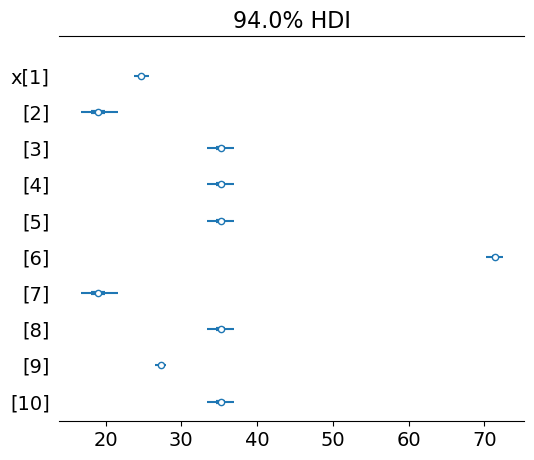

In [18]:
Numba.disable_numba() # Currently the plot_forest function does not work with Numba enabled
az.plot_forest(expected_spend.isel(customer_id=(range(10))), combined=True);

In [19]:
az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,35.258,0.628,34.085,36.45


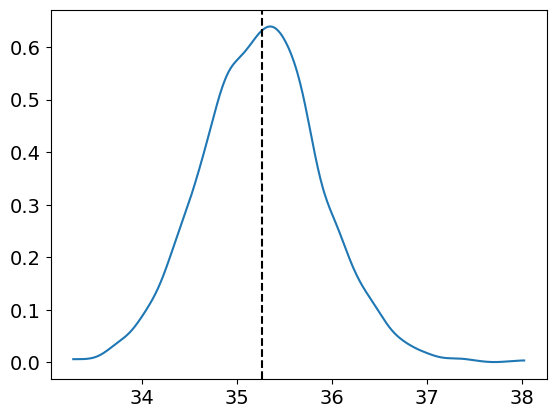

In [20]:
az.plot_dist(expected_spend.mean("customer_id"))
plt.axvline(expected_spend.mean(), color="k", ls="--");